In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlt

In [2]:
df = pd.read_csv('/kaggle/input/weather-seattle/seattle-weather.csv')

In [3]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
features = df.iloc[:,2:5].to_numpy()
features

array([[12.8,  5. ,  4.7],
       [10.6,  2.8,  4.5],
       [11.7,  7.2,  2.3],
       ...,
       [ 7.2,  0.6,  2.6],
       [ 5.6, -1. ,  3.4],
       [ 5.6, -2.1,  3.5]])

In [7]:
target = df.iloc[:,1].to_numpy()

In [8]:
target

array([ 0. , 10.9,  0.8, ...,  0. ,  0. ,  0. ])

In [9]:
#Create dataset for sequential processing
def create_windows(features, target, window_size=10):
    X_windows = []
    Y_windows = []
    for i in range(len(features)-window_size):
        X_windows.append(features[i:i+window_size])
        Y_windows.append(target[i+window_size])
    return np.array(X_windows), np.array(Y_windows)

In [10]:
features_seq,target_seq =create_windows(features,target) 

In [11]:
features_seq[0]

array([[12.8,  5. ,  4.7],
       [10.6,  2.8,  4.5],
       [11.7,  7.2,  2.3],
       [12.2,  5.6,  4.7],
       [ 8.9,  2.8,  6.1],
       [ 4.4,  2.2,  2.2],
       [ 7.2,  2.8,  2.3],
       [10. ,  2.8,  2. ],
       [ 9.4,  5. ,  3.4],
       [ 6.1,  0.6,  3.4]])

In [12]:
target_seq[0]

0.0

Pytorch loader

In [13]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
dataset = TensorDataset(torch.tensor(features_seq).float(),torch.tensor(target_seq).float())

In [14]:
len(dataset)

1451

In [15]:
#do random split
total_size = len(dataset)
train_size = int(0.8*total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size

train_set,valid_set,test_set = random_split(dataset,[train_size,valid_size,test_size])

In [16]:
train_loader = DataLoader(train_set,shuffle = True)
valid_loader = DataLoader(valid_set,shuffle = True)
test_loader = DataLoader(test_set,shuffle = True)

Models

In [17]:
import torch.nn as nn

In [18]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()  # Corrected super() usage
        self.rnn = nn.RNN(
            input_size=3,
            hidden_size=32,
            num_layers=2,
            batch_first=True
        )
        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)  # Initialize hidden state (num_layers, batch_size, hidden_size)
        out, _ = self.rnn(x, h0)  # Forward pass through RNN
        #print(out)  # Optional: For debugging purposes
        out = self.fc1(out[:, -1, :])  # Use the last time step's output
        return out


In [19]:
model = RNN()


In [20]:
input_seq = torch.tensor(features_seq[0], dtype=torch.float32).unsqueeze(0)  # (1, sequence_length, input_size)
output = model(input_seq)
print("Model Output:", output)

Model Output: tensor([[-0.4989]], grad_fn=<AddmmBackward0>)


Pytorch training loop

In [21]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(),lr=1e-3)

In [22]:
# Function to train the model
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
       # Lists to store loss values
    train_losses = []
    val_losses = []
    model.to(device)
    best_val_loss = float('inf')  # To track the best validation loss

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0

        # Training Loop
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.unsqueeze(1).to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            train_loss += loss.item() * inputs.size(0)  # Accumulate training loss

        # Average training loss for this epoch
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        # Validation Loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():  # No gradient tracking during validation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        # Print loss for every epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Best model saved at epoch {epoch + 1}')
    return train_losses,val_losses

In [23]:
# Plot function for training and validation loss
import matplotlib.pyplot as plt
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
train(model,train_loader,valid_loader,criterion,optimizer,num_epochs=50)

Epoch [1/50], Train Loss: 40.8226, Val Loss: 58.7123
Best model saved at epoch 1
Epoch [2/50], Train Loss: 39.2951, Val Loss: 58.1406
Best model saved at epoch 2
Epoch [3/50], Train Loss: 38.7307, Val Loss: 57.5348
Best model saved at epoch 3
Epoch [4/50], Train Loss: 38.1030, Val Loss: 58.6913
Epoch [5/50], Train Loss: 37.7009, Val Loss: 57.3104
Best model saved at epoch 5
Epoch [6/50], Train Loss: 37.5643, Val Loss: 55.6881
Best model saved at epoch 6
Epoch [7/50], Train Loss: 37.4099, Val Loss: 56.4436
Epoch [8/50], Train Loss: 36.8656, Val Loss: 59.7685
Epoch [9/50], Train Loss: 36.7468, Val Loss: 56.5062
Epoch [10/50], Train Loss: 36.3055, Val Loss: 54.5988
Best model saved at epoch 10
Epoch [11/50], Train Loss: 35.6024, Val Loss: 56.1182
Epoch [12/50], Train Loss: 36.3325, Val Loss: 54.3761
Best model saved at epoch 12
Epoch [13/50], Train Loss: 35.9604, Val Loss: 56.2360
Epoch [14/50], Train Loss: 36.1409, Val Loss: 55.2278
Epoch [15/50], Train Loss: 35.5036, Val Loss: 58.6498
E

([40.822638390260366,
  39.29509586729682,
  38.7306905240748,
  38.10298800268273,
  37.700857449321724,
  37.56429045460986,
  37.4098918474545,
  36.865591240221995,
  36.74682927099963,
  36.3054825259542,
  35.602350880220826,
  36.33246790156663,
  35.960425253888616,
  36.14092739061722,
  35.50358539487332,
  36.67522086814719,
  35.933609540167886,
  35.72945049349385,
  34.9960674116614,
  36.744058218400156,
  36.297632970484116,
  35.50184892574616,
  34.197004171592944,
  34.20882171461131,
  33.44833159211701,
  33.70788225883792,
  33.00321996438144,
  33.31943902806548,
  32.19134134383221,
  32.248644775139226,
  32.20747061284509,
  31.519820522481563,
  31.411710989312578,
  30.68945567158777,
  29.832291101817876,
  30.764046168904084,
  30.471552252751707,
  29.735894386876605,
  29.582369283860498,
  28.271314502878194,
  27.833908079535973,
  28.089059739813656,
  28.80235668393237,
  26.76270460917577,
  26.35656396879236,
  26.221421260207627,
  26.576384788243

In [25]:
trainloss2,validloss2 = train(model,train_loader,valid_loader,criterion,optimizer,num_epochs=50)

Epoch [1/50], Train Loss: 31.4408, Val Loss: 60.1201
Best model saved at epoch 1
Epoch [2/50], Train Loss: 26.1310, Val Loss: 57.2972
Best model saved at epoch 2
Epoch [3/50], Train Loss: 23.1254, Val Loss: 59.8258
Epoch [4/50], Train Loss: 24.1559, Val Loss: 59.5334
Epoch [5/50], Train Loss: 23.6912, Val Loss: 61.3413
Epoch [6/50], Train Loss: 25.4880, Val Loss: 56.9545
Best model saved at epoch 6
Epoch [7/50], Train Loss: 24.2570, Val Loss: 63.3563
Epoch [8/50], Train Loss: 21.8542, Val Loss: 63.4932
Epoch [9/50], Train Loss: 21.5507, Val Loss: 66.1911
Epoch [10/50], Train Loss: 21.2095, Val Loss: 64.4902
Epoch [11/50], Train Loss: 21.7962, Val Loss: 64.5004
Epoch [12/50], Train Loss: 20.3273, Val Loss: 68.3286
Epoch [13/50], Train Loss: 21.2340, Val Loss: 59.2971
Epoch [14/50], Train Loss: 21.7300, Val Loss: 68.1905
Epoch [15/50], Train Loss: 19.1481, Val Loss: 61.7427
Epoch [16/50], Train Loss: 20.4544, Val Loss: 61.5958
Epoch [17/50], Train Loss: 19.4067, Val Loss: 70.3745
Epoch [

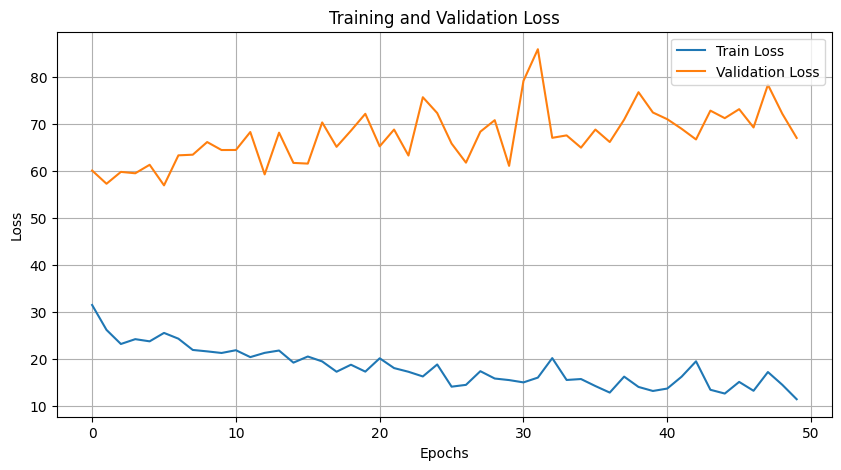

In [26]:
plot_loss(trainloss2,validloss2)

## RNN with regularization dropout

In [27]:
import torch
import torch.nn as nn

class RNNwithRegularization(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected super() usage
        self.rnn = nn.RNN(
            input_size=3,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            #add dropout
            dropout = 0.1
        )
        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)  # Initialize hidden state (num_layers, batch_size, hidden_size)
        out, _ = self.rnn(x, h0)  # Forward pass through RNN
        #print(out)  # Optional: For debugging purposes
        out = self.fc1(out[:, -1, :])  # Use the last time step's output
        return out


In [28]:
model1 = RNNwithRegularization()

In [29]:
optimizer = optim.Adam(model1.parameters(),lr=1e-3)
trainloss,validloss =train(model1,train_loader,valid_loader,criterion,optimizer,num_epochs=50)

Epoch [1/50], Train Loss: 41.6348, Val Loss: 64.6603
Best model saved at epoch 1
Epoch [2/50], Train Loss: 40.0991, Val Loss: 58.1642
Best model saved at epoch 2
Epoch [3/50], Train Loss: 38.8200, Val Loss: 58.4129
Epoch [4/50], Train Loss: 38.3384, Val Loss: 56.8582
Best model saved at epoch 4
Epoch [5/50], Train Loss: 37.7468, Val Loss: 61.8653
Epoch [6/50], Train Loss: 37.9917, Val Loss: 58.6824
Epoch [7/50], Train Loss: 37.4085, Val Loss: 57.4664
Epoch [8/50], Train Loss: 37.4632, Val Loss: 57.6109
Epoch [9/50], Train Loss: 36.9386, Val Loss: 56.6647
Best model saved at epoch 9
Epoch [10/50], Train Loss: 36.5990, Val Loss: 56.3073
Best model saved at epoch 10
Epoch [11/50], Train Loss: 36.6750, Val Loss: 57.5576
Epoch [12/50], Train Loss: 37.0376, Val Loss: 57.1208
Epoch [13/50], Train Loss: 36.1694, Val Loss: 58.9509
Epoch [14/50], Train Loss: 36.4635, Val Loss: 56.6791
Epoch [15/50], Train Loss: 35.9841, Val Loss: 56.2861
Best model saved at epoch 15
Epoch [16/50], Train Loss: 35

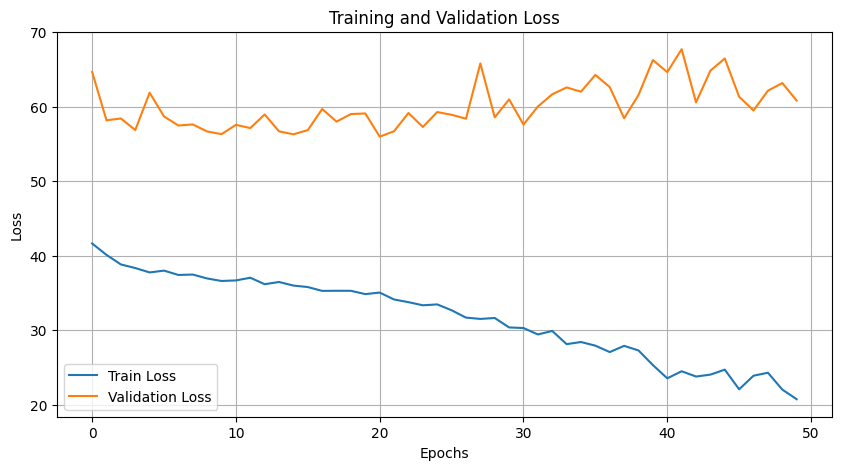

In [30]:
plot_loss(trainloss,validloss)

In [31]:
import torch
import torch.nn as nn

class RNNwithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected super() usage
        self.rnn = nn.RNN(
            input_size=3,
            hidden_size=32,
            num_layers=2,
            batch_first=True
        )
        self.bn  = nn.LayerNorm(32)
        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)  # Initialize hidden state (num_layers, batch_size, hidden_size)
        out, _ = self.rnn(x, h0)  # Forward pass through RNN
        #print(out)  # Optional: For debugging purposes
        out = self.bn(out)
        out = self.fc1(out[:, -1, :])  # Use the last time step's output
        return out


In [32]:
modelb = RNNwithBatchNorm()

In [33]:
optimizer = optim.Adam(modelb.parameters(),lr=1e-3)
trainlossb,validlossb= train(modelb,train_loader,valid_loader,criterion,optimizer,num_epochs=50)

Epoch [1/50], Train Loss: 40.4344, Val Loss: 64.5317
Best model saved at epoch 1
Epoch [2/50], Train Loss: 39.2333, Val Loss: 57.9591
Best model saved at epoch 2
Epoch [3/50], Train Loss: 38.3478, Val Loss: 57.9124
Best model saved at epoch 3
Epoch [4/50], Train Loss: 38.1725, Val Loss: 55.9036
Best model saved at epoch 4
Epoch [5/50], Train Loss: 37.5996, Val Loss: 59.1108
Epoch [6/50], Train Loss: 37.2806, Val Loss: 58.1320
Epoch [7/50], Train Loss: 37.3271, Val Loss: 59.4910
Epoch [8/50], Train Loss: 36.8094, Val Loss: 58.9307
Epoch [9/50], Train Loss: 36.7751, Val Loss: 56.0040
Epoch [10/50], Train Loss: 36.6046, Val Loss: 56.3071
Epoch [11/50], Train Loss: 37.1877, Val Loss: 59.0056
Epoch [12/50], Train Loss: 36.1822, Val Loss: 60.1119
Epoch [13/50], Train Loss: 34.8180, Val Loss: 58.4255
Epoch [14/50], Train Loss: 35.1361, Val Loss: 58.4773
Epoch [15/50], Train Loss: 35.2748, Val Loss: 57.4984
Epoch [16/50], Train Loss: 35.2586, Val Loss: 56.5588
Epoch [17/50], Train Loss: 34.404

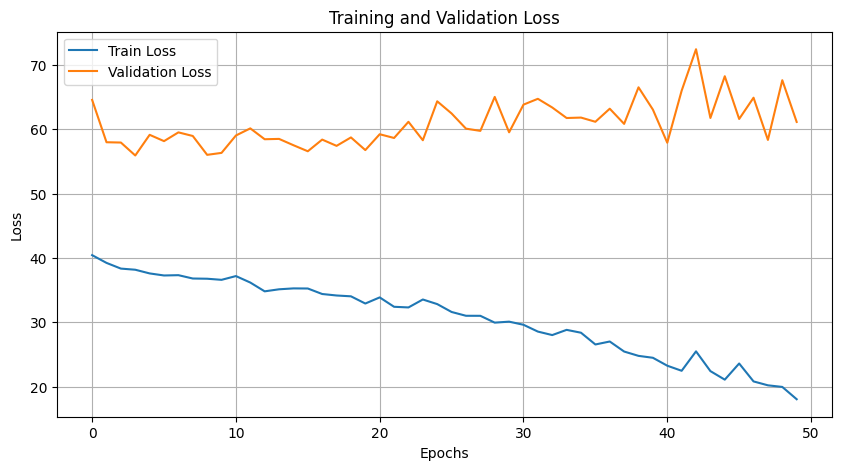

In [34]:
plot_loss(trainlossb,validlossb)

## LSTM model

In [35]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected super() usage
        self.lstm = nn.LSTM(
            input_size=3,
            hidden_size=50,
            num_layers=2,
            batch_first=True
        )
        #self.bn  = nn.LayerNorm(32)
        self.fc1 = nn.Linear(50, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 50)  # Initialize hidden state (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(2, x.size(0), 50)
        out, _ = self.lstm(x, (h0,c0))  # Forward pass through RNN
        #print(out)  # Optional: For debugging purposes
        out = self.fc1(out[:, -1, :])  # Use the last time step's output
        return out


In [36]:
model3 = LSTM()

In [37]:
optimizer = optim.Adam(params = model3.parameters(),lr=1e-2)
trainloss3,validloss3 = train(model3,train_loader,valid_loader,criterion,optimizer,num_epochs=50)

Epoch [1/50], Train Loss: 42.1390, Val Loss: 61.7308
Best model saved at epoch 1
Epoch [2/50], Train Loss: 42.2663, Val Loss: 62.0352
Epoch [3/50], Train Loss: 42.1953, Val Loss: 61.3961
Best model saved at epoch 3
Epoch [4/50], Train Loss: 41.9710, Val Loss: 61.2424
Best model saved at epoch 4
Epoch [5/50], Train Loss: 42.0466, Val Loss: 61.2742
Epoch [6/50], Train Loss: 42.0908, Val Loss: 64.2010
Epoch [7/50], Train Loss: 42.1255, Val Loss: 61.2252
Best model saved at epoch 7
Epoch [8/50], Train Loss: 42.1713, Val Loss: 61.9914
Epoch [9/50], Train Loss: 43.4206, Val Loss: 61.3799
Epoch [10/50], Train Loss: 42.6633, Val Loss: 61.8580
Epoch [11/50], Train Loss: 43.0439, Val Loss: 62.5122
Epoch [12/50], Train Loss: 42.4473, Val Loss: 61.4228
Epoch [13/50], Train Loss: 42.8045, Val Loss: 61.0345
Best model saved at epoch 13
Epoch [14/50], Train Loss: 42.2651, Val Loss: 61.8619
Epoch [15/50], Train Loss: 42.0242, Val Loss: 61.4353
Epoch [16/50], Train Loss: 41.9292, Val Loss: 63.0998
Epoc

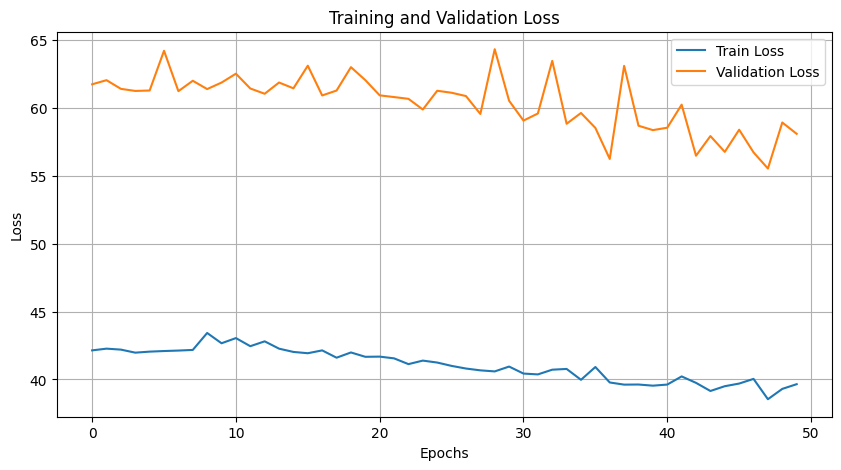

In [38]:
plot_loss(trainloss3,validloss3)

## GRU model

In [39]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self):
        super().__init__()  # Corrected super() usage
        self.gru = nn.GRU(
            input_size=3,
            hidden_size=32,
            num_layers=4,
            batch_first=True,
            #add dropout
            dropout = 0.1
        )
        self.fc1 = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(4, x.size(0), 32)  # Initialize hidden state (num_layers, batch_size, hidden_size)
        out, _ = self.gru(x, h0)  # Forward pass through RNN
        #print(out)  # Optional: For debugging purposes
        out = self.fc1(out[:, -1, :])  # Use the last time step's output
        return out


In [40]:
model_gru = GRU()

In [41]:
optimizer= optim.Adam(model_gru.parameters(),lr =1e-3)
trainloss_g,validloss_g = train(model_gru,train_loader,valid_loader, criterion,optimizer, num_epochs = 50)

Epoch [1/50], Train Loss: 41.7871, Val Loss: 61.0826
Best model saved at epoch 1
Epoch [2/50], Train Loss: 40.8683, Val Loss: 61.2399
Epoch [3/50], Train Loss: 41.5044, Val Loss: 59.6304
Best model saved at epoch 3
Epoch [4/50], Train Loss: 40.0093, Val Loss: 62.4969
Epoch [5/50], Train Loss: 39.9140, Val Loss: 58.3983
Best model saved at epoch 5
Epoch [6/50], Train Loss: 39.5480, Val Loss: 59.4517
Epoch [7/50], Train Loss: 39.1363, Val Loss: 59.1910
Epoch [8/50], Train Loss: 38.6367, Val Loss: 57.1634
Best model saved at epoch 8
Epoch [9/50], Train Loss: 38.0675, Val Loss: 58.4336
Epoch [10/50], Train Loss: 37.8401, Val Loss: 57.3094
Epoch [11/50], Train Loss: 37.7348, Val Loss: 56.8772
Best model saved at epoch 11
Epoch [12/50], Train Loss: 37.4038, Val Loss: 56.2606
Best model saved at epoch 12
Epoch [13/50], Train Loss: 36.9095, Val Loss: 56.1576
Best model saved at epoch 13
Epoch [14/50], Train Loss: 36.7437, Val Loss: 56.3222
Epoch [15/50], Train Loss: 36.3976, Val Loss: 56.8712


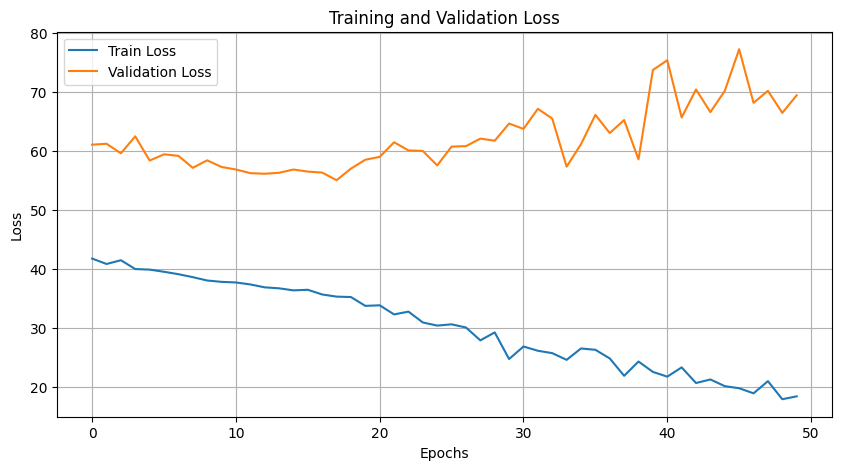

In [42]:
plot_loss(trainloss_g,validloss_g)

## Evaluation of all models

In [43]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_regression(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs).cpu().numpy()
            all_preds.extend(outputs)
            all_targets.extend(targets.cpu().numpy())

    # Calculate MSE and MAE
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)

    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')

    return all_preds, all_targets

# Plot function to compare predicted vs actual values
def plot_predictions(predictions, actuals, title):
    plt.figure(figsize=(10, 5))
    plt.plot(predictions, label='Predicted', marker='o')
    plt.plot(actuals, label='Actual', marker='x')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



In [44]:
# Example usage
def plot_and_evals(model,test_loader,val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Assuming val_loader and test_loader are DataLoader objects
    print("Validation Results:")
    val_preds, val_targets = evaluate_regression(model, val_loader, device)

    print("\nTest Results:")
    test_preds, test_targets = evaluate_regression(model, test_loader, device)

    # Plotting the predictions vs actual values for validation and test sets
    plot_predictions(val_preds, val_targets, title="Validation Set: Predicted vs Actual")
    plot_predictions(test_preds, test_targets, title="Test Set: Predicted vs Actual")


Validation Results:
MSE: 67.0720
MAE: 5.1415

Test Results:
MSE: 52.9327
MAE: 4.1145


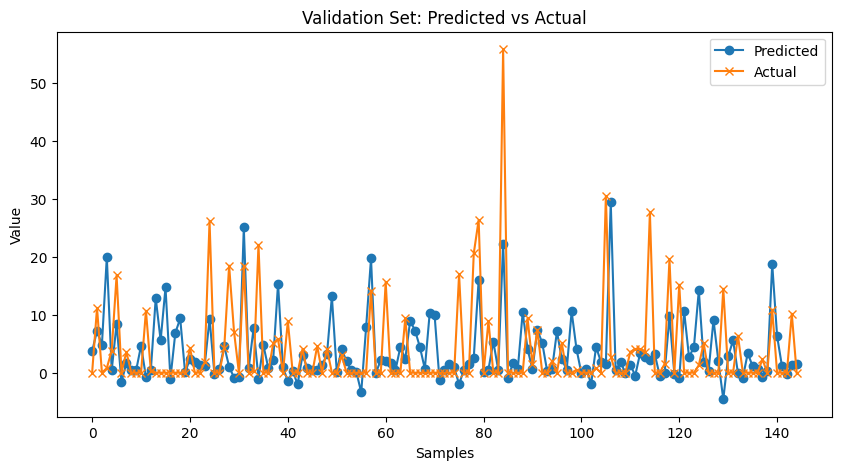

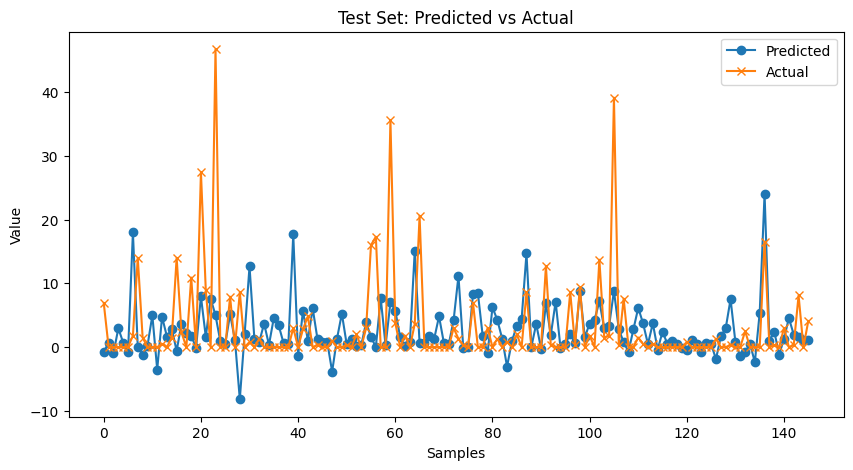

In [45]:
plot_and_evals(model,test_loader,valid_loader)

Model with LSTM

Validation Results:
MSE: 58.0852
MAE: 4.3938

Test Results:
MSE: 45.2773
MAE: 3.6386


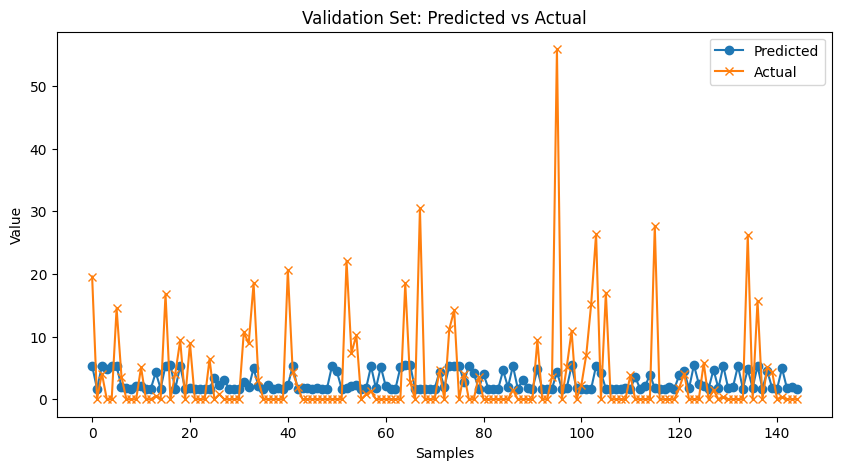

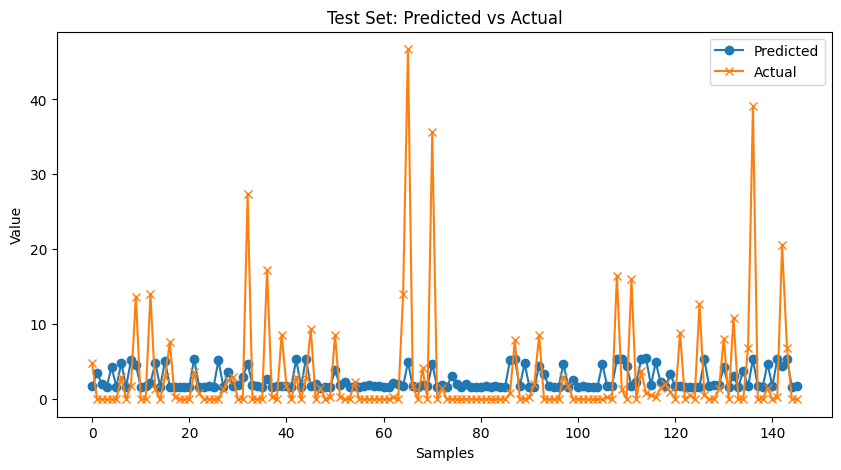

In [46]:
plot_and_evals(model3,test_loader,valid_loader)

GRU model

Validation Results:
MSE: 69.4488
MAE: 4.3545

Test Results:
MSE: 60.2276
MAE: 3.8469


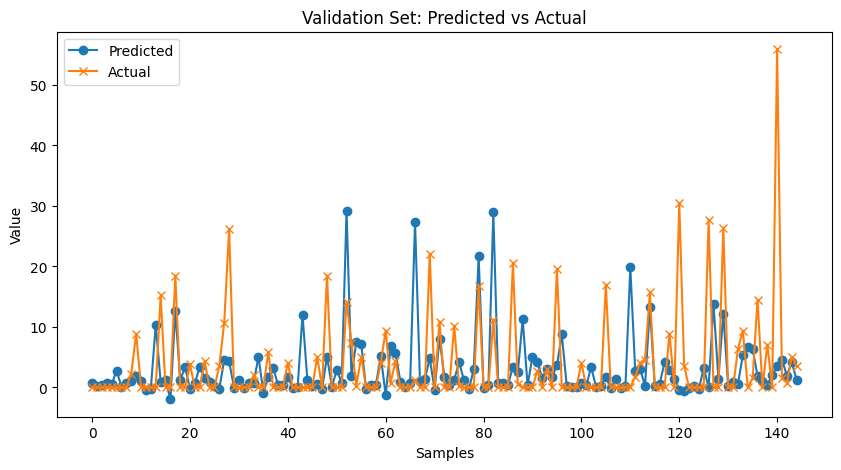

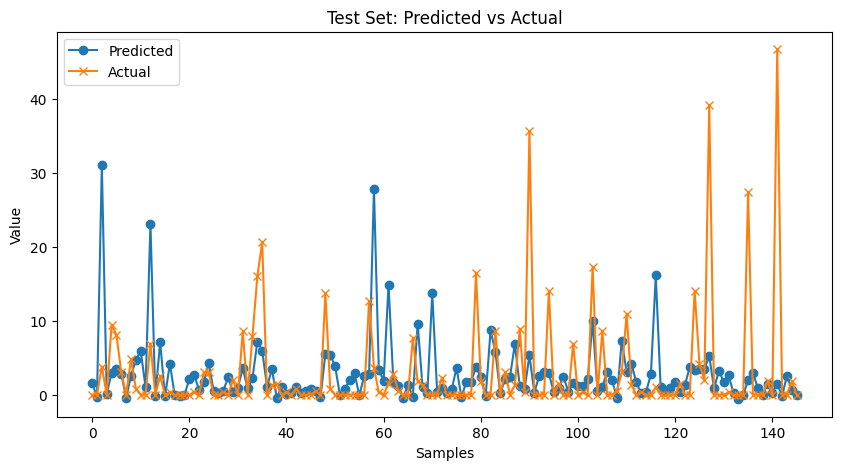

In [47]:
plot_and_evals(model_gru,test_loader,valid_loader)